In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geohash2 as gh

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

from xgboost import DMatrix, train
import lightgbm as lgb

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import RMSprop,AdamW
import keras

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

pd.options.display.max_rows
pd.set_option('display.max_rows', None)
pd.options.display.max_columns
pd.set_option('display.max_columns', None)

In [2]:
df_train=pd.read_csv('Train.csv')
df_test=pd.read_csv('Test.csv')

# Data Preprocessing 

In [3]:
percent_missing = df_train.isnull().sum() * 100/ len(df_train)
pd.DataFrame({'column_name': df_train.columns,'percent_missing': percent_missing})

,column_name,percent_missing
id,id,0.000000
site_id,site_id,0.000000
site_latitude,site_latitude,0.000000
site_longitude,site_longitude,0.000000
city,city,0.000000
country,country,0.000000
date,date,0.000000
hour,hour,0.000000
sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density,60.859869
sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_column_number_density_amf,60.859869


In [4]:
thresh = len(df_train) * 0.5
df_train.dropna(axis=1, inplace=True, thresh=thresh)

In [5]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)

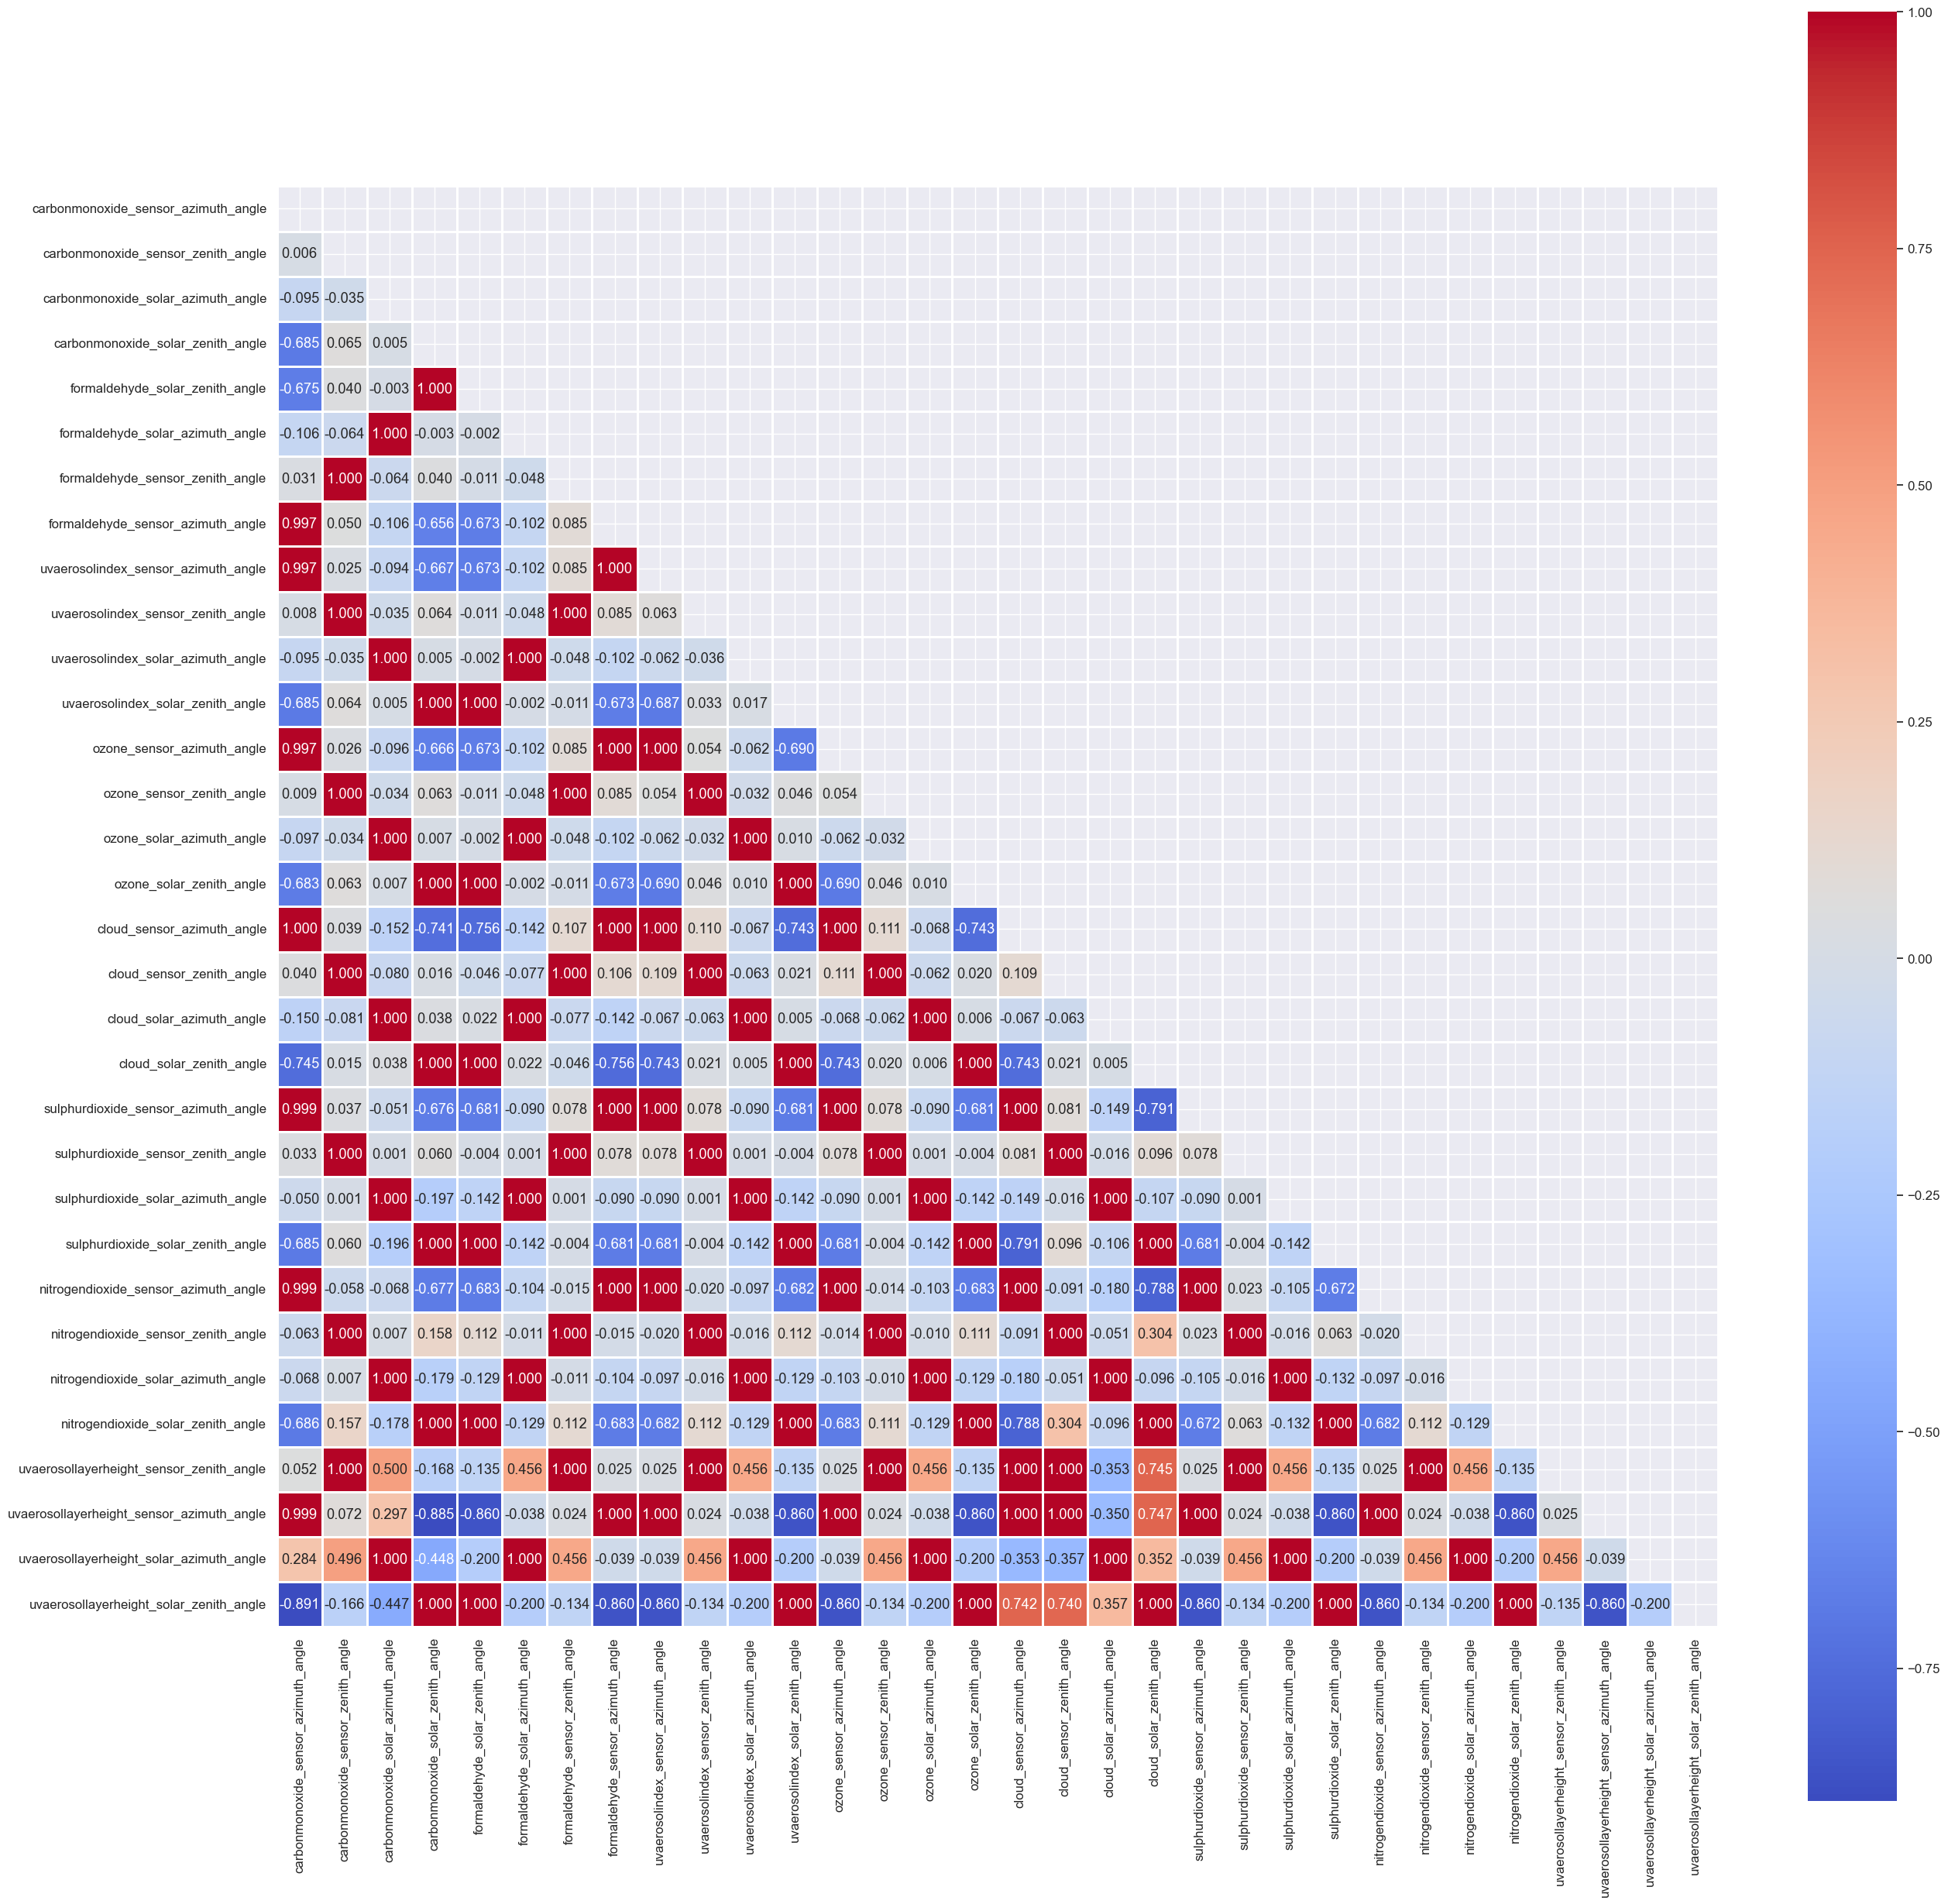

In [6]:
angle_columns = df_combined.filter(like='angle').columns
df_angle = df_combined[angle_columns]
sns.set(font_scale=1.1)
corr_df= df_angle.corr()
mask = np.triu(corr_df.corr())
plt.figure(figsize=(30, 30))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm', square=True, mask=mask, linewidth=1, cbar=True)
plt.show()

We can notice that all the angle columns are highly correlated. For this reason, we will extract only the columns that have the minimum missing values meaning : `uvaerosolindex_sensor_azimuth_angle`, `uvaerosolindex_sensor_zenith_angle`, `uvaerosolindex_solar_azimuth_angle`,  `uvaerosolindex_solar_zenith_angle`. 

In [7]:
angle_columns = df_combined.filter(like='angle').columns.tolist()
columns_to_drop_from_angle_columns = {'uvaerosolindex_sensor_azimuth_angle',
                   'uvaerosolindex_sensor_zenith_angle',
                   'uvaerosolindex_solar_azimuth_angle',
                   'uvaerosolindex_solar_zenith_angle'}
angle_columns = list(set(angle_columns) - columns_to_drop_from_angle_columns)
df_combined = df_combined.drop(columns=angle_columns)

In [8]:
columns_to_fill = ['uvaerosolindex_sensor_azimuth_angle','uvaerosolindex_sensor_zenith_angle','uvaerosolindex_sensor_altitude',
                  'uvaerosolindex_absorbing_aerosol_index']
df_combined[columns_to_fill] = df_combined[columns_to_fill].fillna(df_combined[columns_to_fill].mean())

Accroding to [solar angles](https://arka360.com/ros/solar-angles/), we will use the different mathematical equations to fill our missing values: 
* $Declination_{-}angle=arcsin(0.39795.\cos(0.98563(N-173)))$ : where $N$ : Number of days since $1^{st}$ January. 
* $Hour_{-}angle=15.(Hour-12)$
* $Altitude_{-}angle=arcsin(cos(L)*cos(D)*cos(\omega)+sin(L)*sin(D))$ where : 
1. D : Declination angle 
2. L : Latitude 
3. $\omega$ : hour angle 
* $azimuth_{-}angle=arcos(\dfrac{sin(a)*sin(L)-sin(D)}{cos(a)*cos(L)})$ where : 
1. a : altitude angle 
2. L : Latitude 
3. Declination angle 
* $zenith_{-}angle=arcos(sin(D)*sin(L)+cos(D)*cos(L)*cos(\omega))$

In [9]:
def calculate_declination_angle(N):
    return np.arcsin(0.39795 * np.cos(0.98563 * (N - 173)))

In [10]:
df_combined['date'] = pd.to_datetime(df_combined['date'])
df_combined['N'] = (df_combined['date'] - pd.to_datetime(df_combined['date'].dt.year, format='%Y')) / np.timedelta64(1, 'D')
df_combined['Declination_angle'] = df_combined['N'].apply(calculate_declination_angle)

df_combined['hour_angle']=15*(df_combined['hour']-12)

altitude_angle_rad = np.arcsin(
    np.sin(np.radians(df_combined['site_latitude'])) * np.sin(np.radians(df_combined['Declination_angle'])) +
    np.cos(np.radians(df_combined['site_latitude'])) * np.cos(np.radians(df_combined['Declination_angle'])) * np.cos(np.radians(df_combined['hour_angle']))
)
df_combined['altitude_angle'] = np.degrees(altitude_angle_rad)

In [11]:
def calculate_azimuth(altitude_angle, site_latitude, declination_angle):
    return (np.sin(altitude_angle) * np.sin(site_latitude) - np.sin(declination_angle)) / (np.cos(altitude_angle) * np.cos(site_latitude))

def calculate_zenith(declination_angle, site_latitude, hour_angle):
    return np.arcsin(np.sin(declination_angle) * np.sin(site_latitude) + np.cos(declination_angle) * np.cos(site_latitude) * np.cos(hour_angle))

In [12]:
df_combined['uvaerosolindex_solar_azimuth_angle'] = np.where(
    df_combined['uvaerosolindex_solar_azimuth_angle'].isnull(),
    calculate_azimuth(df_combined['altitude_angle'], df_combined['site_latitude'], df_combined['Declination_angle']),
    df_combined['uvaerosolindex_solar_azimuth_angle']
)

df_combined['uvaerosolindex_solar_zenith_angle'] = np.where(
    df_combined['uvaerosolindex_solar_zenith_angle'].isnull(),
    calculate_zenith(df_combined['Declination_angle'], df_combined['site_latitude'], df_combined['hour_angle']),
    df_combined['uvaerosolindex_solar_zenith_angle']
)

In [13]:
df_combined.drop('N',axis=1,inplace=True)
df_combined.drop('altitude_angle',axis=1,inplace=True)

In [14]:
percent_missing = df_combined.isnull().sum() * 100/ len(df_combined)
pd.DataFrame({'column_name': df_combined.columns,'percent_missing': percent_missing})

,column_name,percent_missing
id,id,0.000000
site_id,site_id,0.000000
site_latitude,site_latitude,0.000000
site_longitude,site_longitude,0.000000
city,city,0.000000
country,country,0.000000
date,date,0.000000
hour,hour,0.000000
month,month,0.000000
carbonmonoxide_co_column_number_density,carbonmonoxide_co_column_number_density,42.942694


In [15]:
thresh = len(df_combined) * 0.5
df_combined.dropna(axis=1, inplace=True, thresh=thresh)

In [16]:
def fill_group(df,function,agg,target='pm2_5'): 
    """
    This function is useful to fill the missing values based on one feature
    
    df : our dataframe that we will work on 
    agg : our feature that we will grouped our data by 
    target : by default is pm2_5
    function : the function that we will use, it could be mean, median, sum,...
    
    """
    nan_columns = df.columns[df.isna().any()].tolist()
    nan_columns.remove(target)
    for col in nan_columns:
        df[col] = df[col].fillna(df.groupby([agg])[col].transform(function))
    return df

In [17]:
df_combined=fill_group(df_combined,'mean','month')

# Feature Engineering 

In [18]:
def delete_lists(df,to_drop):
    """
    
    This function is useful to drop a list from our dataframe
    df: our dataframe
    to_drop : the list to be dropped 
    
    """
    df.drop(to_drop, axis=1, inplace=True)
    return df

In [19]:
def groupby_features(df, agglist,target='pm2_5'):
    """
    This function is useful to create new columns that calculate the mean, std, min, max and skew based on a feature
    
    df: our dataframe
    agglist: the list of features that we will grouped by on 
    target : our target and it is pm2_5 by default
    """
    for col in agglist:
        df[f"{col}__mean"] = df.groupby(col)[target].transform('mean')
        df[f"{col}__std"] = df.groupby(col)[target].transform('std')
        df[f"{col}__min"] = df.groupby(col)[target].transform('min')
        df[f"{col}__max"] = df.groupby(col)[target].transform('max')
    return df

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30216\979318212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data.month = monthly_data.month.map(map_dict)


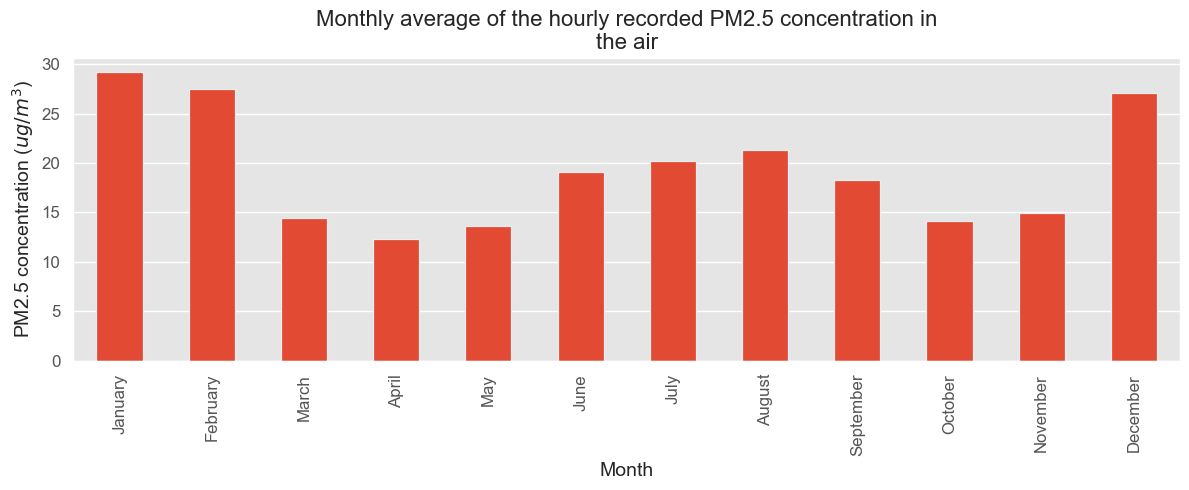

In [20]:
monthly_data = df_combined[['month','pm2_5']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration ($ug/m^3$)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [25]:
df_combined['hour'].unique()

array([13, 12, 14, 10, 11], dtype=int64)

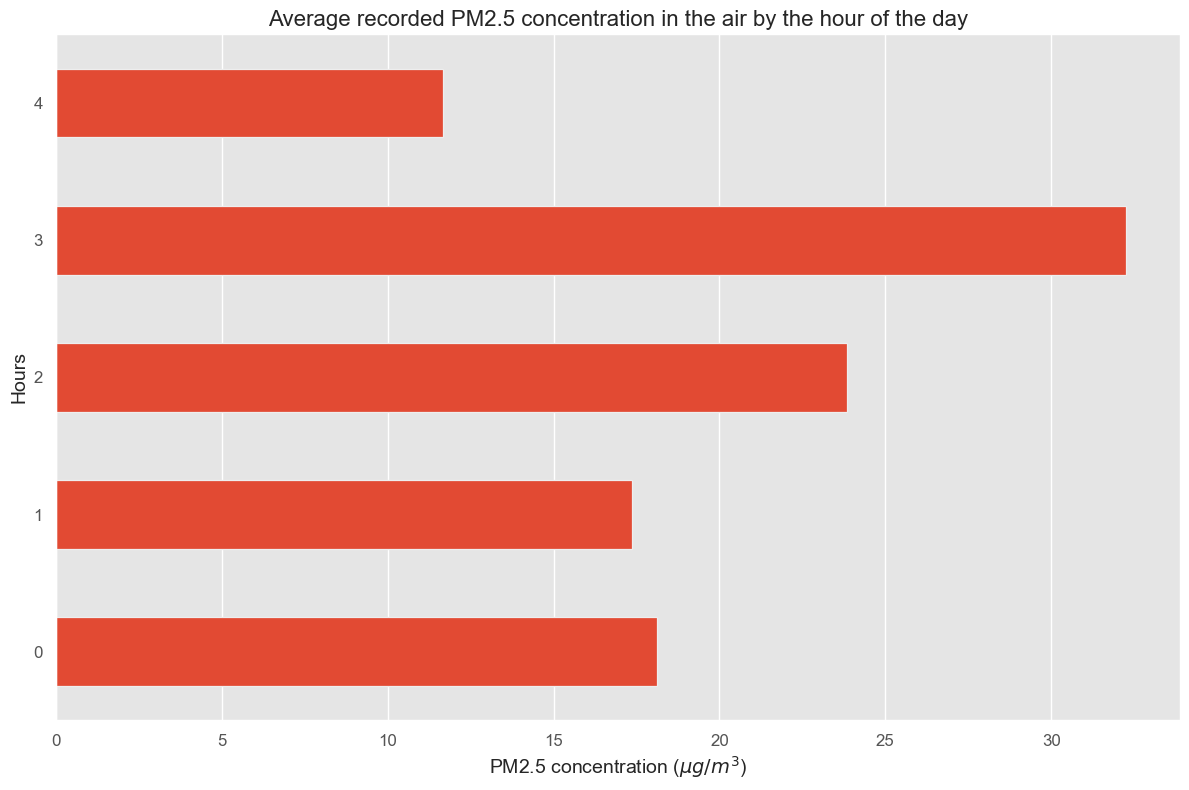

In [28]:
hourly_data = df_combined[['hour', 'pm2_5']]
hrs = [10, 11, 12, 13, 14]
hour_dict = {hour: index for index, hour in enumerate(hrs)}
hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data['hour'] = hourly_data['hour'].map(hour_dict)
hourly_data = hourly_data.dropna(subset=['hour'])
hourly_data = hourly_data.set_index('hour')
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12, 8), legend=False, kind='barh', linewidth=0.9)
    plt.ylabel('Hours', fontsize=14)
    plt.xlabel('PM2.5 concentration ($\mu g/m^3$)', fontsize=14)
    plt.title('Average recorded PM2.5 concentration in the air by the hour of the day', fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [29]:
df_combined=groupby_features(df_combined,['month'],'pm2_5')
df_combined=groupby_features(df_combined,['hour'],'pm2_5')

In [30]:
df_combined["season"] = df_combined["month"].map({
                                        1: 1, 2: 1, 3: 1,    # Months 1, 2, 3 belong to season 1
                                        4: 2, 5: 2, 6: 2,    # Months 4, 5, 6 belong to season 2
                                        7: 3, 8: 3, 9: 3,    # Months 7, 8, 9 belong to season 3
                                        10: 4, 11: 4, 12: 4  # Months 10, 11, 12 belong to season 4
                                    })

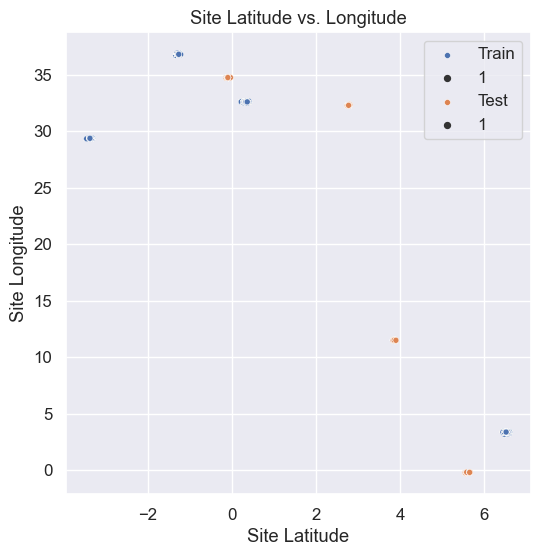

In [31]:
plt.figure(figsize=(6, 6))

# Plotting scatter plot for df_train
sns.scatterplot(data=df_train, x='site_latitude', y='site_longitude', size=1, label='Train')

# Plotting scatter plot for df_test
sns.scatterplot(data=df_test, x='site_latitude', y='site_longitude', size=1, label='Test')

plt.xlabel('Site Latitude')
plt.ylabel('Site Longitude')
plt.title('Site Latitude vs. Longitude')
plt.legend()
plt.show()

Despite the fact that the training dataset and testing dataset are coming from different distributions, we notice that there are some sites that are close between the two datasets. We will use then the geohash encoder. 

In [32]:
df_combined['geohash'] = df_combined.apply(lambda row: gh.encode(row['site_latitude'], row['site_longitude'], precision=5), axis=1)
df_combined['geohash']=df_combined['geohash'].astype('category')
df_combined['lat_lng'] = round(df_combined['site_latitude'], 0).astype(str) + "_" + round(df_combined['site_longitude'], 0).astype(str)
df_combined['lat_lng']=df_combined['lat_lng'].astype('category')

In [33]:
to_drop=['id','site_id','country','city','date','cloud_cloud_top_pressure','cloud_cloud_top_height',
         'cloud_cloud_base_pressure','cloud_cloud_base_height']
df_combined=delete_lists(df_combined,to_drop)

In [34]:
df_train=df_combined[(~df_combined['pm2_5'].isna())]
df_test=df_combined[(df_combined['pm2_5'].isna())]

In [35]:
def remove_outliers_from_target(df, target_column, threshold=3):
    mean = df[target_column].mean()
    std_dev = df[target_column].std()
    df['z_score'] = (df[target_column] - mean) / std_dev
    df = df[abs(df['z_score']) < threshold]
    df = df.drop(columns=['z_score'])
    return df

In [36]:
df_train = remove_outliers_from_target(df_train, 'pm2_5')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30216\3595086869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = (df[target_column] - mean) / std_dev


# Modeling 

In [37]:
X=df_train.drop(['pm2_5'],axis=1)
y=df_train['pm2_5']
test=df_test.drop(['pm2_5'],axis=1)

In [38]:
categorical_features = ['geohash','lat_lng']
numeric_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_transformed = preprocessor.fit_transform(X)
test_transformed = preprocessor.transform(test)

In [39]:
seed = 42
tf.config.experimental.enable_op_determinism()
keras.utils.set_random_seed(seed)

In [40]:
def create_model_ann(input_dim, learning_rate=0.001):
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_dim=input_dim)) 
    model.add(Dense(64, activation='relu')) 
    model.add(Dropout(0.15))    
    model.add(Dense(64, activation='relu')) 
    model.add(Dropout(0.15))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(1))  
    
    learning_rate=0.05
    
    optimizer = AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

50/50 [==============================] - 0s 668us/step
Fold 1 RMSE Train: 10.05
Fold 1 RMSE Val: 10.60


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


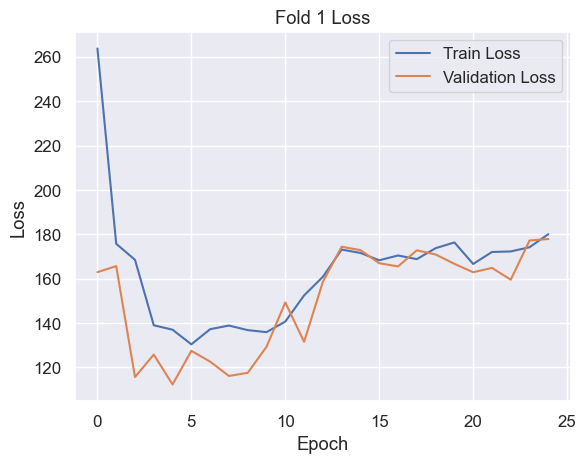

50/50 [==============================] - 0s 693us/step
Fold 2 RMSE Train: 11.28
Fold 2 RMSE Val: 11.29


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


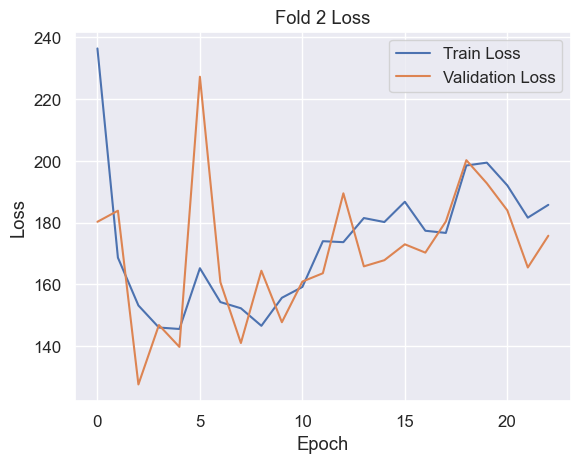

50/50 [==============================] - 0s 685us/step
Fold 3 RMSE Train: 10.11
Fold 3 RMSE Val: 10.82


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


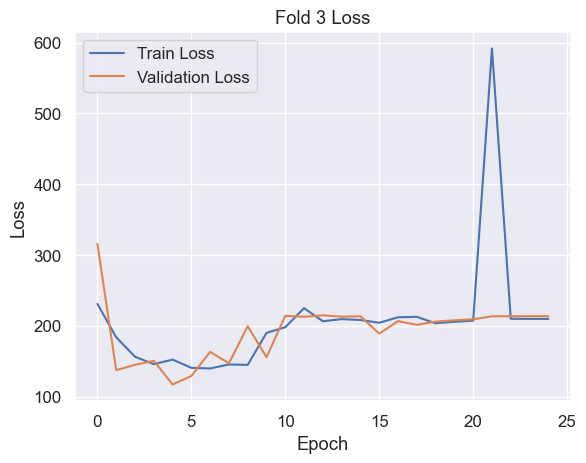

50/50 [==============================] - 0s 677us/step
Fold 4 RMSE Train: 10.68
Fold 4 RMSE Val: 11.24


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


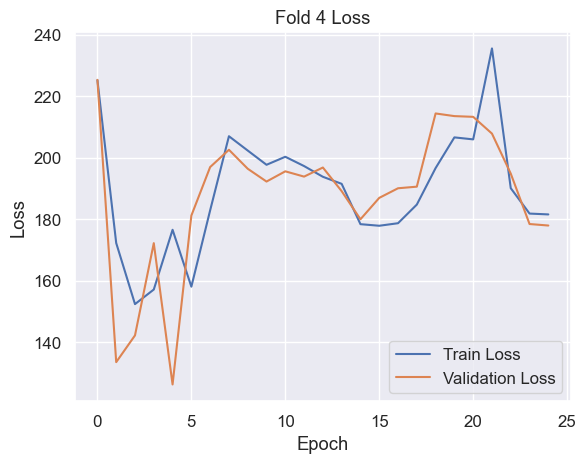

50/50 [==============================] - 0s 685us/step
Fold 5 RMSE Train: 9.96
Fold 5 RMSE Val: 10.28


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


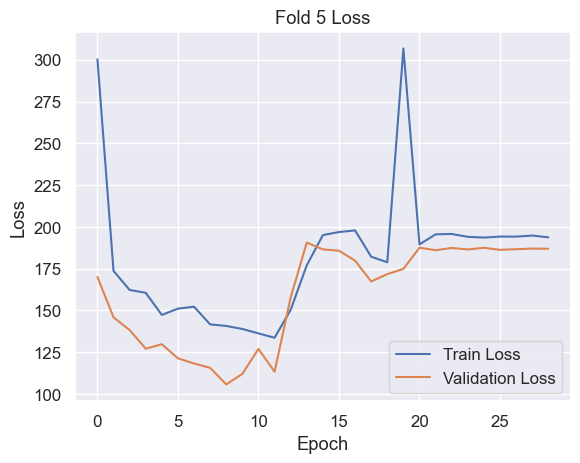

87/87 [==============================] - 0s 727us/step
Mean VAL RMSE: 10.85
Mean TRAIN RMSE: 10.42


In [42]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
val_scores = []
train_scores = []
NN=[]

for fold_num, (train_index, val_index) in enumerate(kf.split(X_transformed)):
    X_train, X_val = X_transformed[train_index], X_transformed[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = create_model_ann(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        min_delta=0.001,  # minimum amount of change to count as an improvement
        patience=20,      # how many epochs to wait before stopping
        restore_best_weights=True
    )
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=300, batch_size=32, callbacks=[early_stopping], verbose=0)
    
    y_pred_train = model.predict(X_train).flatten()
    y_pred_val = model.predict(X_val).flatten()
    
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
    
    print(f'Fold {fold_num + 1} RMSE Train: {rmse_train:.2f}')
    print(f'Fold {fold_num + 1} RMSE Val: {rmse_val:.2f}')
    
    train_scores.append(rmse_train)
    val_scores.append(rmse_val)
    
    # Visualize the losses
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_num + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_pred_test = model.predict(test_transformed).flatten()
    NN.append(y_pred_test)

print(f'Mean VAL RMSE: {np.mean(val_scores):.2f}')
print(f'Mean TRAIN RMSE: {np.mean(train_scores):.2f}')

In [43]:
categorical_features = ['geohash','lat_lng']
numeric_features = df_combined.drop(['pm2_5'],axis=1).columns.difference(categorical_features)
scaler_standard = StandardScaler()
labelencoder = LabelEncoder()
df_combined_scaler = scaler_standard.fit_transform(df_combined[numeric_features])
df_combined_scaler_df = pd.DataFrame(df_combined_scaler, columns=numeric_features)
df_combined_1 = pd.concat([df_combined[categorical_features], df_combined_scaler_df], axis=1)
df_combined_1['geohash_encoded'] = labelencoder.fit_transform(df_combined_1['geohash'])
df_combined_1['lat_lng_encoded'] = labelencoder.fit_transform(df_combined_1['lat_lng'])
df_combined_1 = df_combined_1.drop(columns=['geohash','lat_lng'])
df_combined_1['pm2_5'] =df_combined['pm2_5']
df_train_1=df_combined_1[(~df_combined['pm2_5'].isna())]
df_test_1=df_combined_1[(df_combined['pm2_5'].isna())]
df_train_1 = remove_outliers_from_target(df_train_1, 'pm2_5')
X1=df_train_1.drop(['pm2_5'],axis=1)
y1=df_train_1['pm2_5']
test1=df_test_1.drop(['pm2_5'],axis=1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30216\3595086869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = (df[target_column] - mean) / std_dev


In [44]:
# Initialize the variables
preds1Ridge = []
scores = []
train_scores = []

def create_model_ridge():
    
    num_folds = 5
    folds = GroupKFold(n_splits=num_folds)
    
    for fold_num, (train_index, test_index) in enumerate(folds.split(X1, y1, groups=X1['geohash_encoded'])):
        X_train, X_val = X1.iloc[train_index], X1.iloc[test_index]
        y_train, y_val = y1.iloc[train_index], y1.iloc[test_index]
        
        model = Ridge(random_state=42)
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        
        print(f'*** Fold {fold_num + 1} ***')
        print(f'Training RMSE: {train_rmse:.2f}')
        print(f'Validation RMSE: {val_rmse:.2f}')
        
        train_scores.append(train_rmse)
        scores.append(val_rmse)
        
        y_pred_test = model.predict(test1)
        preds1Ridge.append(y_pred_test)
        
        feature_importance = np.abs(model.coef_)
        feature_names = X.columns
        sorted_idx = np.argsort(feature_importance)[::-1]
        
        top_n = 20
        plt.figure(figsize=(10, 6))
        plt.bar(range(top_n), feature_importance[sorted_idx][:top_n], align='center')
        plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx][:top_n], rotation=90)
        plt.xlabel('Feature')
        plt.ylabel('Feature Importance')
        plt.title('Top 20 Feature Importances')
        plt.show()

    print(f'Mean Training RMSE: {np.mean(train_scores):.2f}')
    print(f'Mean Validation RMSE: {np.mean(scores):.2f}')
    return preds1Ridge, model

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*** Fold 1 ***
Training RMSE: 11.54
Validation RMSE: 11.47


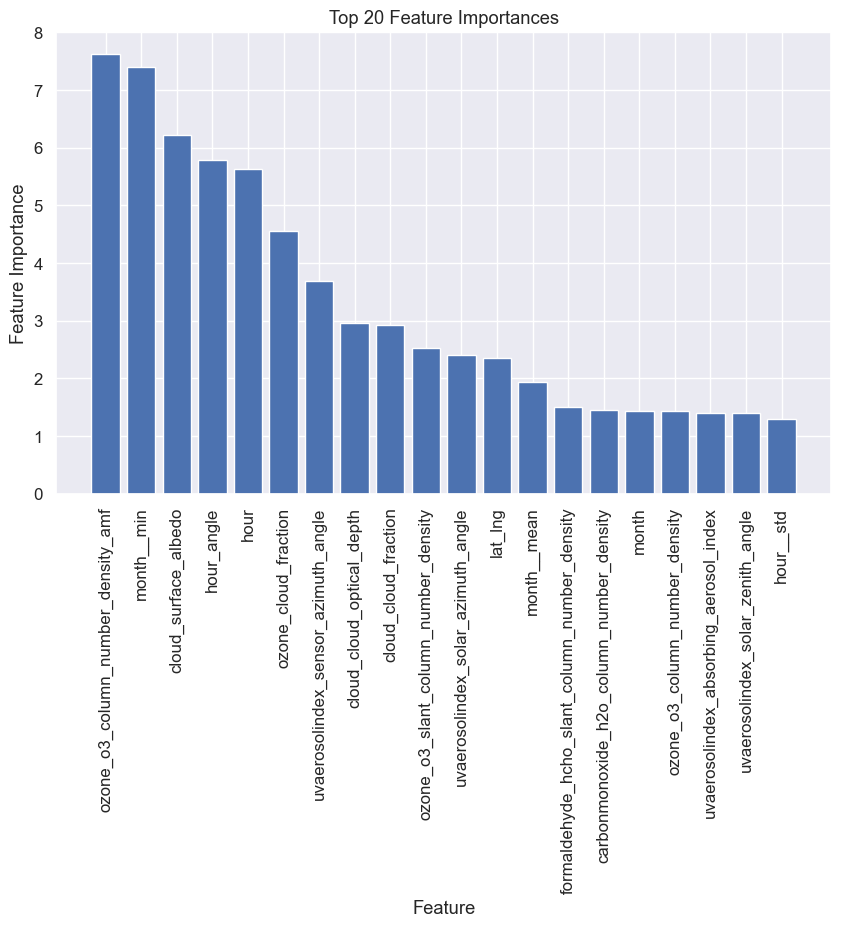

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*** Fold 2 ***
Training RMSE: 11.67
Validation RMSE: 10.92


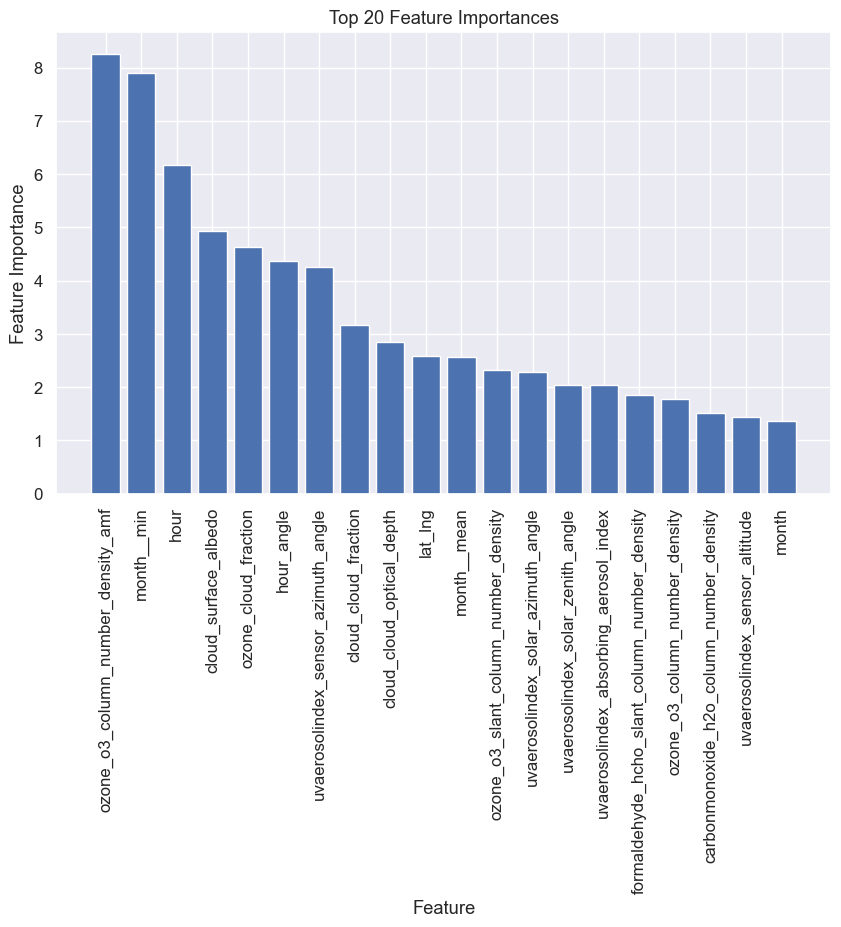

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*** Fold 3 ***
Training RMSE: 10.80
Validation RMSE: 14.28


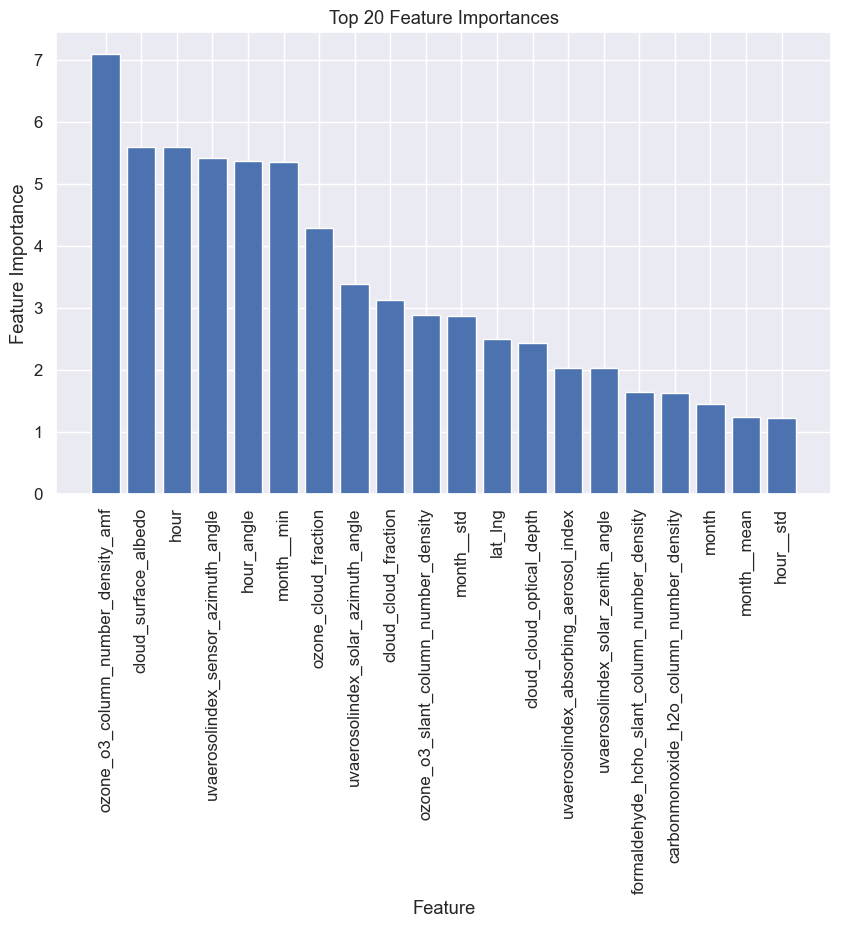

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*** Fold 4 ***
Training RMSE: 12.02
Validation RMSE: 9.47


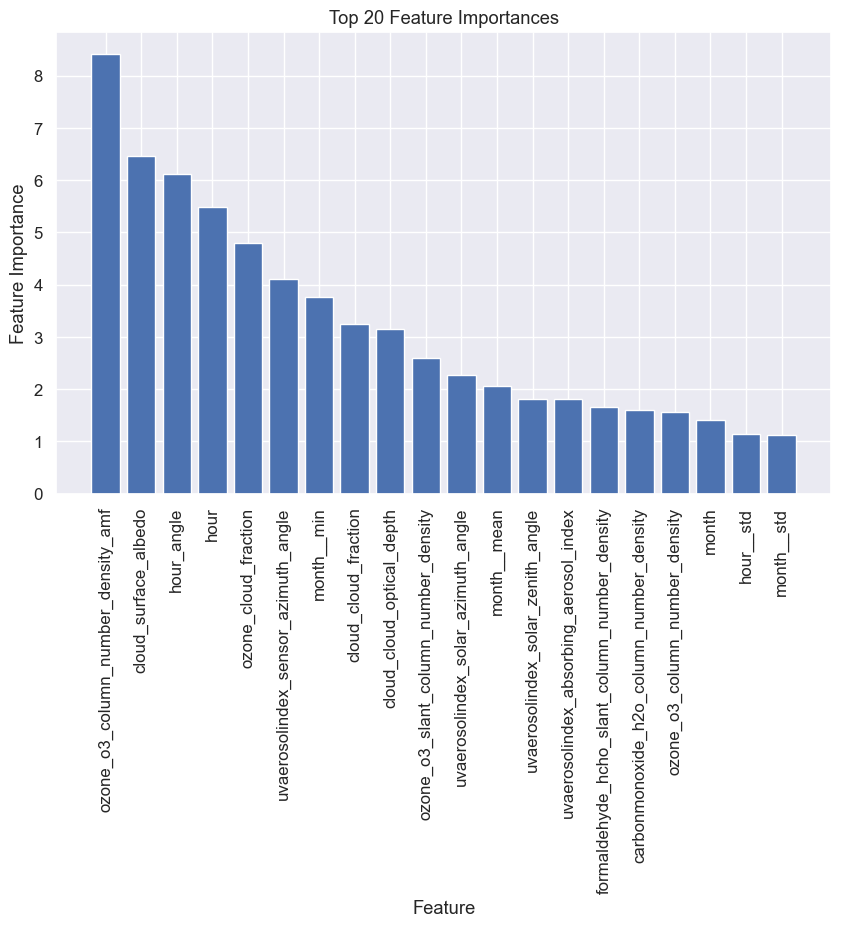

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*** Fold 5 ***
Training RMSE: 11.27
Validation RMSE: 12.79


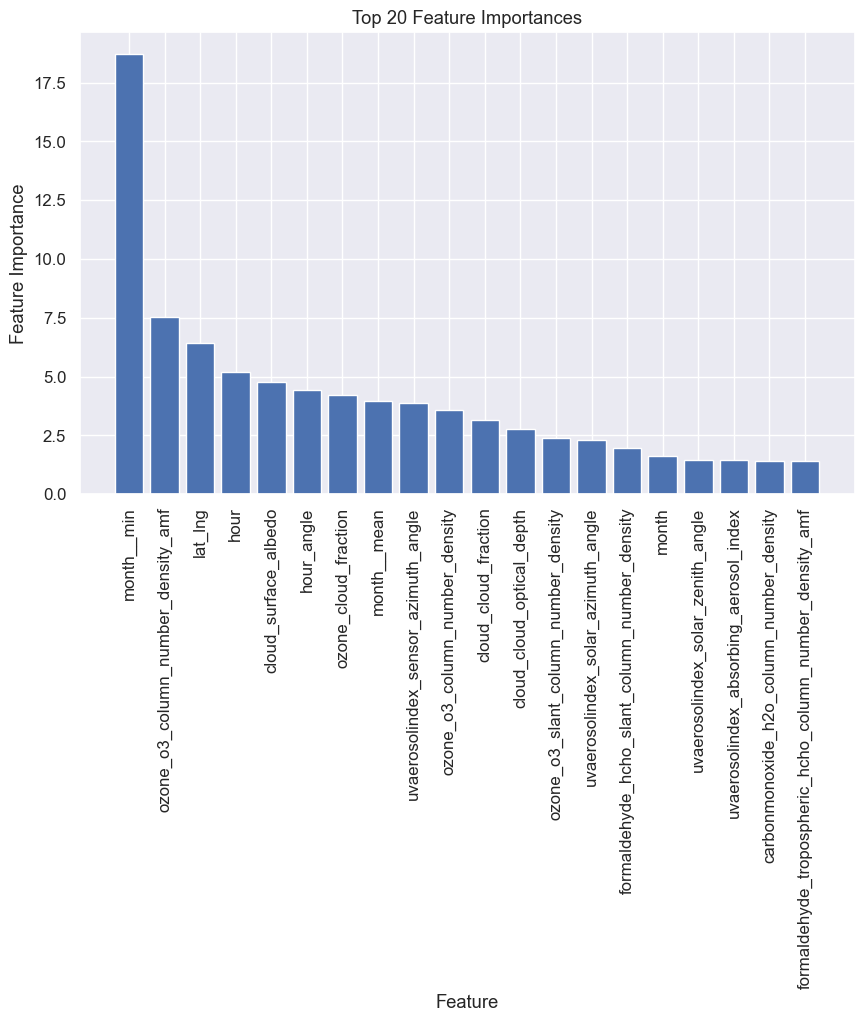

Mean Training RMSE: 11.46
Mean Validation RMSE: 11.78


In [45]:
preds1ridge,rd=create_model_ridge()

In [46]:
y_ridge=np.mean(preds1ridge, axis=0)
y_ann=np.mean(NN, axis=0)

In [47]:
sub = pd.read_csv('SampleSubmission.csv')
sub['pm2_5'] = y_ann*0.9025+y_ridge*0.0975
sub.to_csv('ann+ridge.csv', index=False)